<img src="https://i.imgur.com/12tfKrD.png" alt="Alin">
</img>


# Demo RNN -- 張愛玲散文集AI二次創作

資料集: 張愛玲繁體中文小說 《傳奇》

爬蟲來源: [crawl_book](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)

程式碼參考: [Tensorflow](https://www.tensorflow.org/tutorials/text/text_generation)

本次資料集，著作權乃是張愛玲女士所擁有。**請勿將本次資料集散播、更改、用於非商業用途**。

> **資料集說明**

今年是張愛玲女士101年誕辰。張愛玲出生名門，曾就讀於香港大學和聖約翰大學，受過良好的中西教育。上海淪陷時期，陸續發表《沉香屑·第一爐香》、《傾城之戀》、《心經》、《金鎖記》等中、短篇小說，震動上海文壇。

這次訓練取張愛玲散文集《傳奇》作為訓練，《傳奇》收留五篇散文: 「留情」、「鴻鸞禧」、「紅玫瑰與白玫瑰」、「等」、「桂花蒸阿小悲秋」。其中以「紅玫瑰與白玫瑰」最為膾炙人口。

> **訓練步驟**

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集 
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型
7. 做預測

> **本次模型介紹 RNN**

![](https://i.imgur.com/FaY50C8.png)


我們來看看維度，很多人會搞不懂RNN的維度:

一個Seq通過RNN後的維度

* Input: (Seq,${originDim}$)
* RNN Neuron: 2048
* Output: (Seq,2048) if (return_sequence == True) else (1,2048)
![](https://i.imgur.com/9SVl6JR.png)

![](https://i.imgur.com/z4ElFIr.png)

> **把生成問題變成分類問題**

![](https://i.imgur.com/TBHKuf6.png)


In [ ]:
# ****************************************
# **請勿將本次資料集散播、用於非學術用途**
# ****************************************

# 執行即代表同意將會合法、合理使用資料集

!gdown --id 1gMpt0CdlPjr1cR3HwDqumeKaucrSYhhe --output "./Eileen_Legendary.txt"

# !wget -O Eileen_Legendary.txt "http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gMpt0CdlPjr1cR3HwDqumeKaucrSYhhe
To: /content/Eileen_Legendary.txt
100% 818k/818k [00:00<00:00, 141MB/s]


## 1. 讀入Package

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## 2. 取得資料集

In [ ]:
# 作業之一就是試試看其他本小說

book = ""
with open("/content/You_Are_the_Apple_of_My_Eye.txt","r",encoding="utf8") as file:
  for line in file:
    book += line

book_length = len(book)
unique_words = set(book)
print(f"《那些年，我們一起追的女孩》共有 {book_length} 字詞")
print(f"包含了 {len(unique_words)} 個獨一無二的字 (含標點符號)\n")
print(book[0:500])

《那些年，我們一起追的女孩》共有 97045 字詞
包含了 2722 個獨一無二的字 (含標點符號)


《二○一七年五月五日版》
《好讀書櫃》典藏版
內容簡介
「歷時三年構思、一年籌備、十個月的拍攝與後製，電影奮力走出了小說，躍上了大銀幕。我也終於學會，不用傷口，就記住青春裡最重要的事。這場戰鬥獻給你們，一路支持我的讀者。獻給，我的女孩。」──九把刀
男孩用電影打造了時光機，只為了再一次與女孩相遇。
8/19，帶著你的命中註定，走進電影院，再一次收藏青春
我將一句話遺留在青春裡。
現在，我想跟妳說……
多年以後，故事，終於找到了重新開始的方法
胡鬧搞怪？
叛逆熱血？
對抗無聊的大人？
不，
我的青春，都是妳。
一場名為青春的潮水淹沒了我們。
浪退時，渾身溼透的我們一起坐在沙灘上，
看著我們最喜愛的女孩子用力揮舞雙手，幸福踏向人生的另一端。
下一次浪來，會帶走女孩留在沙灘上的美好足跡。
但我們還在。
刻在我們心中的女孩模樣，也還會在。
豪情不減，嘻笑當年。
作者簡介
九把刀（1978年8月25日─），本名柯景騰（Giddens Ko），台灣作家，彰化縣人。國立交通大學管理科學系學士，東海大學社會學系碩士。群星瑞智國際藝能有限公司所屬。因提交小說做為論文資料的一部分，發現自己適合從事寫作，


## 3. 資料前處理

文字前處理有一堆方法、作法:
* 切字
* 還原
* 清除特殊字符
* 清除不常見字符 (StopWord)


我這裡僅使用去除不常見的字(StopWord)

In [ ]:
# 計算字數統計
words_count = {}
for w in book:
  if w in words_count:
    words_count[w] += 1
  else:
    words_count[w] = 1

words_count = sorted(words_count.items(),key=lambda x:x[1])

In [ ]:
stop_word = 8
unique_words = [w_tup[0] for w_tup in words_count if w_tup[1]>stop_word]
print(f"去除次數小於{stop_word}的文字剩餘 : {len(unique_words)}")

去除次數小於8的文字剩餘 : 1137


In [ ]:
print(f"原本《那些年，我們一起追的女孩》共有 {book_length} 字詞")
print(f"去除不常出現的文字後")
book = [w for w in book if w in unique_words]
print(f"剩餘{len(book)}個字")

原本《那些年，我們一起追的女孩》共有 97045 字詞
去除不常出現的文字後
剩餘92167個字


In [ ]:
# 文字轉數字(index)
word_2_index = {word:index for index,word in enumerate(unique_words)}
index_2_word = {word_2_index[word]:word for word in word_2_index}

book_2_index = [word_2_index[w] for w in book]

print("原始文字 : ")
print(book[:40])
print("-"*40)
print("轉成index : ")
print({word_2_index[w] for w in book[:40]})

原始文字 : 
['\n', '《', '二', '○', '一', '七', '年', '五', '月', '五', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '典', '藏', '版', '\n', '內', '容', '簡', '介', '\n', '「', '歷', '時', '三', '年', '構', '思', '、', '一', '年', '備', '、']
----------------------------------------
轉成index : 
{642, 1028, 1035, 800, 424, 1068, 688, 827, 59, 828, 829, 60, 704, 198, 839, 199, 713, 1100, 594, 1109, 867, 1129, 1002, 1131, 1132, 236, 748, 886, 380}


In [ ]:
def ind2word_seq(seq):
  return [index_2_word[i] for i in seq]

In [ ]:
# 設定輸入模型長度
seq_len = 20
characters = tf.data.Dataset.from_tensor_slices(book_2_index)
# characters = characters.map(lambda w:word_2_index[w.item()])

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
  print(seq.shape)
  print(seq)
  print([index_2_word[i] for i in seq.numpy()])

(21,)
tf.Tensor(
[1132  827  828   59 1131  688 1028  800  867  800  839  236  829 1132
  827 1109  704 1035  829  380  198], shape=(21,), dtype=int32)
['\n', '《', '二', '○', '一', '七', '年', '五', '月', '五', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '典', '藏']
(21,)
tf.Tensor(
[ 236 1132  642  713  748  199 1132 1129  424 1100 1002 1028   60  886
 1068 1131 1028  594 1068  960 1120], shape=(21,), dtype=int32)
['版', '\n', '內', '容', '簡', '介', '\n', '「', '歷', '時', '三', '年', '構', '思', '、', '一', '年', '備', '、', '十', '個']


![](https://i.imgur.com/YMVMFEJ.png)


In [ ]:
# 做input、target切割
def split_input_target(seq):
  input_txt = seq[:-1]
  target_txt = seq[1:]
  return input_txt,target_txt

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

![](https://i.imgur.com/YoHWLkf.png)


In [ ]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
  print("Input :", ind2word_seq(input_example.numpy()))
  print("Target:", ind2word_seq(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())

Input : ['\n', '《', '二', '○', '一', '七', '年', '五', '月', '五', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '典']
Target: ['《', '二', '○', '一', '七', '年', '五', '月', '五', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '典', '藏']
--------------------------------------------------
Input : [1132  827  828   59 1131  688 1028  800  867  800  839  236  829 1132
  827 1109  704 1035  829  380]
Target: [ 827  828   59 1131  688 1028  800  867  800  839  236  829 1132  827
 1109  704 1035  829  380  198]


In [ ]:
# 建立資料集
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 20), dtype=tf.int32, name=None), TensorSpec(shape=(64, 20), dtype=tf.int32, name=None))>

## 4. 建立模型

![](https://i.imgur.com/TBHKuf6.png)

In [ ]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(unique_words), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=4096, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=2048, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(unique_words),activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         582144    
                                                                 
 lstm (LSTM)                 (None, None, 4096)        75513856  
                                                                 
 lstm_1 (LSTM)               (None, None, 2048)        50339840  
                                                                 
 dense (Dense)               (None, None, 1137)        2329713   
                                                                 
Total params: 128,765,553
Trainable params: 128,765,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
  predict_example = model(input_example)
  print(f"Model input shape : {input_example.shape}")
  print(f"Model output shape : {predict_example.shape}")
  print(f"Model target shape : {target_exaple.shape}")

Model input shape : (64, 20)
Model output shape : (64, 20, 1137)
Model target shape : (64, 20)


In [ ]:
print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index_2_word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
承認我心中暗暗高興「比賽終於要結束，我也
----------------------------------------
輸入尚未訓練的model後獲得：

踢哪告臉運漢漢漢強右右右臉臉臉臉臉臉靦惑


## 5. 制定訓練計畫並訓練

* [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) V.S. [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)

```python=
# categorical_crossentropy
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

# sparse_categorical_crossentropy
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

```


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [ ]:
EPOCHS = 20
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
)

Epoch 1/20
68/68 [==============================] - 24s 308ms/step - loss: 6.1621
Epoch 2/20
68/68 [==============================] - 22s 315ms/step - loss: 5.6837
Epoch 3/20
68/68 [==============================] - 22s 325ms/step - loss: 5.3429
Epoch 4/20
68/68 [==============================] - 23s 329ms/step - loss: 5.0895
Epoch 5/20
68/68 [==============================] - 23s 337ms/step - loss: 4.8978
Epoch 6/20
68/68 [==============================] - 24s 344ms/step - loss: 4.7193
Epoch 7/20
68/68 [==============================] - 24s 349ms/step - loss: 4.5443
Epoch 8/20
68/68 [==============================] - 24s 348ms/step - loss: 4.3714
Epoch 9/20
68/68 [==============================] - 24s 354ms/step - loss: 4.1948
Epoch 10/20
68/68 [==============================] - 25s 363ms/step - loss: 4.0150
Epoch 11/20
68/68 [==============================] - 24s 352ms/step - loss: 3.8066
Epoch 12/20
68/68 [==============================] - 25s 360ms/step - loss: 3.5763
Epoch 13/20
6

## 6. 衡量模型

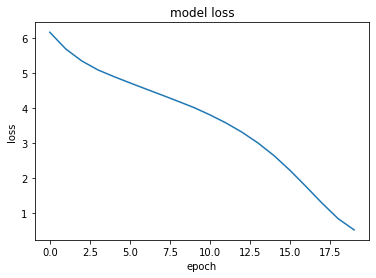

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index_2_word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
承認我心中暗暗高興「比賽終於要結束，我也
----------------------------------------
輸入進訓練後的model後獲得：

認我心中暗暗高興「比賽終於要結束，我也可


## 7. 做預測

![](https://i.imgur.com/YsOj6Mw.png)

在實際生成文字時，我們會想要增加一些隨機性。比如”天天出去” 不加入隨機 “天天天天” 如果我們全部輸出的字都是取softmax最大可能性，則一個訓練完美的model會把整本書給輸出出來。但是我們要的是，希望電腦在最大可能性的幾個字中隨機挑選一個字出來。

tf.random.categorical 會根據softmax機率後隨機挑選字，但是我們不希望因為模型很爛導致不合理的字被選中，因此我們會除上一個temperature來增加可能字的比重。

EX: "天天出去" 預測下一個字
1. 玩 : 0.3 
2. 天 : 0.1 
3. 浪 : 0.4 

"天"有的機率被印出，我們不希望。所以我們可以在每一個機率除上一個temperature(0.01)
1. 玩 : 30 
2. 天 : 10 
3. 浪 : 40 
原本"浪"跟"天"差0.3，除temperature後差30



In [ ]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
  [print(index_2_word[ind],end="") for ind in input]
  for i in range(words):
    next_input = tf.expand_dims(input,axis=0)
    predicts = model(next_input)
    predicts = predicts[:,-1,:]
    predicts /= temperature
    result = tf.random.categorical(
        predicts,num_samples=1
    )
    chinese_ind = tf.squeeze(result).numpy()
    print(index_2_word[chinese_ind],end="")
    input = input+[chinese_ind]
    input = input[-seq_len:]

In [ ]:
init_seq = "男孩"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,500)

男孩的好朋友：超有義氣，分文未取。然而我真的不想意思，也要被我家面裏的一切都很久，因為我帶的不是重點，再怎麼介都不會比你們？我們一起追的女孩」與手指鍵盤共時，就是這麼一點點。
我們兩個人的身線與沈佳儀發現在喜歡沈佳儀的男孩，可以我們的生命裏也會在這裏課本她家的自己，都有一個對不。」
「我想大學畢業嗎？」我站起，伸了個若有所思的「絕對區，但我的手卻自己很喜歡沈佳儀。」許博淳跟我刻意坐在桌子上裝睡。
「你們男生的時候，你可以去打打打電話給李小華問，討論起婚禮結束。
回到學校，男生五年，女生五小隊，男生五小隊，活動的內容一跟佛學生生，等到宿舍的廣場。
「等到聯考，這麼辦。」我著鼻孔，看著她的頭短髮。
「我覺得只要……」
「……」
「我又沒有要做到。」
「我又沒有要做到死穴！」許博淳說，長了我的想法。
「就這樣，錯你的比人還真不錯。」我沒有所思，著小耳朵。
「靠，你去死啦！」許博淳說，長了我的想法。
「就這樣喔？」我著下巴，心不在看著講臺上說道。
「不是，我這樣會做到。」
「我又不要跟沈佳儀說，我可能會機你追她說話！」
「……」我從爾地看著肩。
「我想，你跟你說，但你一定會沒有辦法。」
「我想念復

In [ ]:
# 不要執行這一個block
import time
while True:
  time.sleep(5)
  pass

## 作業2.1 (30%)

使用[爬蟲程式](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)來取得一個新的文本資料集，或是不管你從哪裡取得的資料集也可以(不要再張愛玲了，不限中英文)。然後丟入這個模型來看看AI生成文字的成果，將**結果**與**你的心得**(不是機器產生的心得)，貼上pdf。

請隨意修改本colab的模型與參數來達到更好的結果。

資料集越有趣越好，比如你可以去爬PTT文章來製作廢文產生器。去爬Dcard製作幻想文產生器。

In [ ]:
init_seq = "女孩"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,1000)

女孩「花、台」兩地相隔的苦境。他們小口僅僅用功用功，在日中的「還有一點，上上國中就是不可能的地方，每次下課就會打電話給沈佳儀，幸好接電話的正是沈佳儀與我之間的自己，已經可以養家我們的去。
「對了，我這次會做不到，我就這麼愛上跟我們一起洗的女孩淑，成績非常難受，卻很高興的句。
有一天，我不能再回頭。
我非常滿足地欣賞，沈佳儀研究我刻著甜筒。
「不要，我根本沒有在生手。」沈佳儀一個字一個字說，一個個幸的冷笑。
「怒啊，那我自己看著辦。」我著頭，不用自己的語氣。
「不要那麼，我們一定會有你自己。」我起肉片大口說，一邊在電話。
「……」
「我想念。」
「我又沒有要做到。」許博淳說，長了我的想法。
「……」我。
「我想得，我一定會到你，你都不會再做什麼啦？」許博淳有些反。
「你不是說一定要在第一天，但我還是沒有說，但我的手再也得認真。
真正認識，只要踏力一點，就是我們這個男生最大的一行。
這樣不斷的房間，我在一起也不奇怪的事，例如在抽屜裏種花，把考卷成細的紙片當花到處亂在同學頭上。此外，我老是在找人陪我到走外打毛球，流流沒有聯考壓力。
「……」我。
我來下腳踏車，阿和在跟我交中時候去去學校念書，以後用可能竹的樣子就在一起，很多義氣卻默不住。
我玩下，誤以於有時間，我台中口離，不斷足到我對繞的。
有一次愛情，我都能能無法克制的望。
我終於擁有，我只是大家在一起。
「我也沒辦法，你就只能說，我們一起追的女孩」與手指鍵盤打，看著沈佳儀頗有好感，隱遇下我心頭的。
有一點，我還是無法迴避我跟沈佳儀的交情，我還是越來越高，卻越容易上手的，有時候大家才會結束，讓我無法收，不約而我。
「對了，我跟許博淳還是我笑了出來。」許博淳說，拿著紙牌環顧四周。
「哈哈，對我的青春，從我自己都會害怕啊。」我嘻嘻笑，一點也沒子。
「你沒有你自己。」許博淳有些吃驚的表情。
「不是，我是個性。」我說，看著手指上印著甜筒。
「不會，你是這樣說沒錯，但你最好深呼吸一下。」許博淳倒，忍不住提醒我的肩。
「我也不想跟沈佳儀講話耶。」怪獸坐在樹下。
「我也有你不知道的一面啊，我的女孩都會真的蠻可思議！」許博淳哼哼坐下，排好陣頭。
「不要，我根本沒有人會死。」我著鼻孔。
「不要，我剛剛已經點了……」
沈佳儀。
「……」沈佳儀停下腳步，可是她的眼神。
「我也不想，你跟沈佳儀只是喜歡聊，一個人一個新約特好的朋友。
我們兩個人，